In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.impute import KNNImputer
from scipy import stats
import time
import pickle
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [90]:
df = pd.read_csv("Synthetic_Churn.csv")
df.head()

,Gender,Expertise,Ages,Level1,Level2,Level3,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,Female,beginner,34.0,315,180.0,NaN,monthly,67624.0,employed,medium,00:00-06:00,Active,android,phone,495,medium,4
1,Female,beginner,35.0,106,NaN,NaN,monthly,45968.0,NaN,NaN,06:00-12:00,Active,android,laptop,106,high,1
2,Female,beginner,38.0,327,300.0,319.0,annual,51810.0,NaN,high,12:00-18:00,Active,ios,tablet,946,low,4
3,Female,beginner,31.0,302,319.0,240.0,monthly,59311.0,employed,high,00:00-06:00,Active,ios,tablet,861,low,2
4,Female,beginner,32.0,329,121.0,NaN,annual,67741.0,self_employed,medium,00:00-06:00,Active,android,other,450,medium,4


In [91]:
df.shape

(100000, 17)

We see we have a total of 100000 observations.

In [92]:
df.isna().sum() # check null values

Gender               0
Expertise            0
Ages              6424
Level1               0
Level2           42205
Level3           69607
Subs              8884
Annual_income    23234
Job_status       32234
Commitment       17545
Time                 0
State                0
Platform             0
Device               0
Completed            0
Churn                0
Time counts          0
dtype: int64

We see we have quite a lot of null values. We will fill Level2 and Level3 nulls with 0 as those customers have not progressed to that level yet. 

For other nulls, we will fill using K-Nearest Neighbours imputation after feature selection is concluded.

In [93]:
df["Level2"].fillna(0, inplace=True)
df["Level3"].fillna(0, inplace=True)

In [94]:
df.duplicated().sum() # check for duplicate observations

0

We check the ratio of our target classes.

In [95]:
df['Churn'].value_counts(normalize=True)*100

medium    47.306
high      46.590
low        6.104
Name: Churn, dtype: float64

We see that we have an imbalanced dataset.

In [96]:
# descriptive statistics of our numerical features
df.describe().round(2)

,Ages,Level1,Level2,Level3,Annual_income,Completed,Time counts
count,93576.00,100000.00,100000.00,100000.00,76766.00,100000.00,100000.00
mean,33.18,241.03,122.74,51.56,43476.55,420.61,2.52
std,7.27,69.51,119.87,81.88,13853.79,254.74,0.96
min,20.00,1.00,0.00,0.00,19214.00,1.00,1.00
25%,28.00,199.00,0.00,0.00,31604.25,207.00,2.00
50%,33.00,256.00,119.00,0.00,43497.50,400.00,3.00
75%,38.00,297.00,237.00,131.00,55293.00,616.00,3.00
max,65.00,333.00,333.00,333.00,67794.00,972.00,4.00


In [97]:
# we seperate out our categorical and continuous column names in lists
cate_columns = []
conti_columns = []
for col in df.columns:
    if df[col].dtype == "object":
        cate_columns.append(col)
    else:
        conti_columns.append(col)

In [98]:
df.head()

,Gender,Expertise,Ages,Level1,Level2,Level3,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,Female,beginner,34.0,315,180.0,0.0,monthly,67624.0,employed,medium,00:00-06:00,Active,android,phone,495,medium,4
1,Female,beginner,35.0,106,0.0,0.0,monthly,45968.0,NaN,NaN,06:00-12:00,Active,android,laptop,106,high,1
2,Female,beginner,38.0,327,300.0,319.0,annual,51810.0,NaN,high,12:00-18:00,Active,ios,tablet,946,low,4
3,Female,beginner,31.0,302,319.0,240.0,monthly,59311.0,employed,high,00:00-06:00,Active,ios,tablet,861,low,2
4,Female,beginner,32.0,329,121.0,0.0,annual,67741.0,self_employed,medium,00:00-06:00,Active,android,other,450,medium,4


EDA

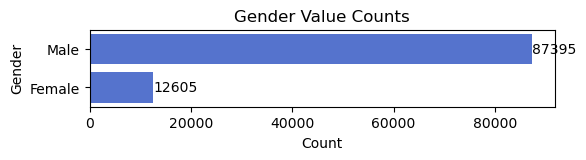

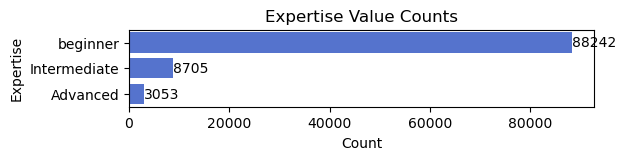

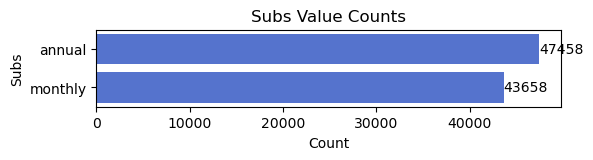

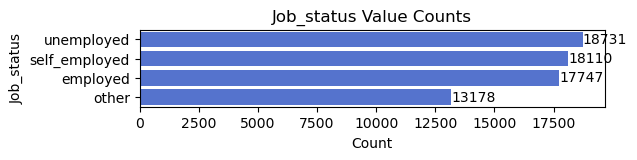

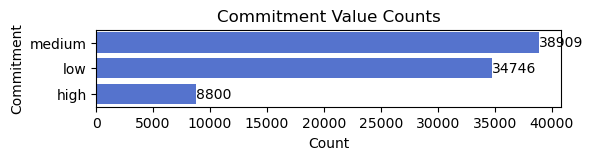

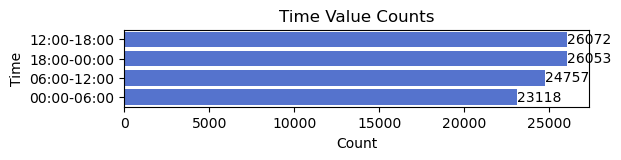

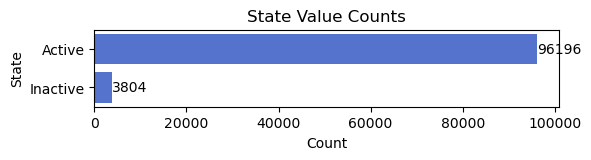

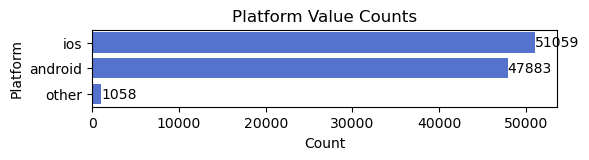

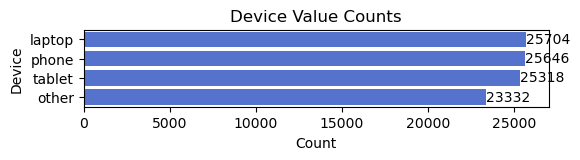

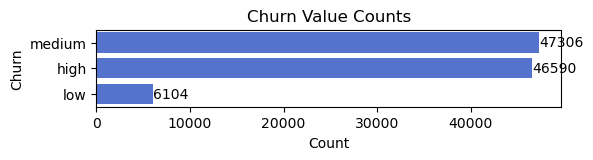

In [99]:
# Bar Plots of all our categorical columns

for col_name in cate_columns:
    x = df[col_name].value_counts()
    y = df[col_name].value_counts().index
    abs_values = df[col_name].value_counts().values

    plt.figure(figsize=(6,1))
    ax = sns.barplot(x = x, y = y, color='royalblue')
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    plt.title(f"{col_name} Value Counts")
    plt.xlabel("Count")
    plt.ylabel(f"{col_name}")
    plt.show()

OBSERVATIONS:
- There is a major class imbalance in Gender, majority are Male
- Major class imbalance in Expertise, majority are beginners
- Higher commitment level is low compared to the medium and low commitment levels
- State is extremely imbalanced with majority being Active
- Majority people tend to use android and ios
- Device types are balanced
- Class imbalance in our target variable Churn

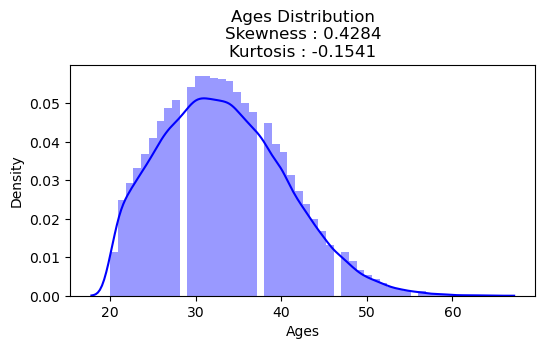

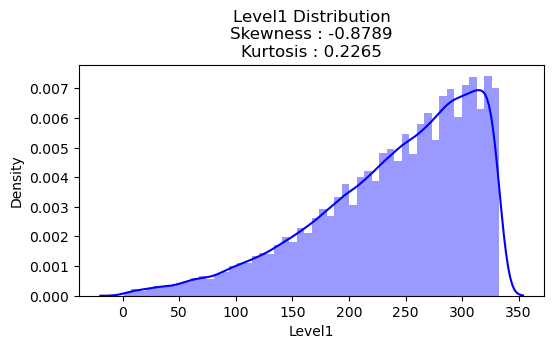

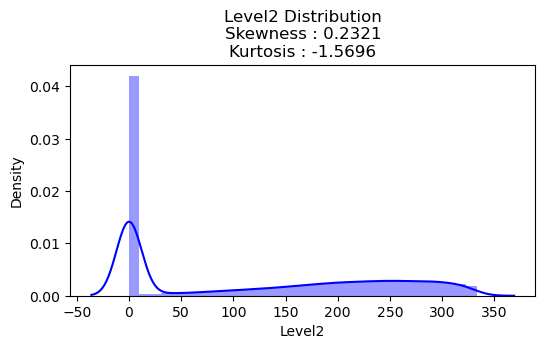

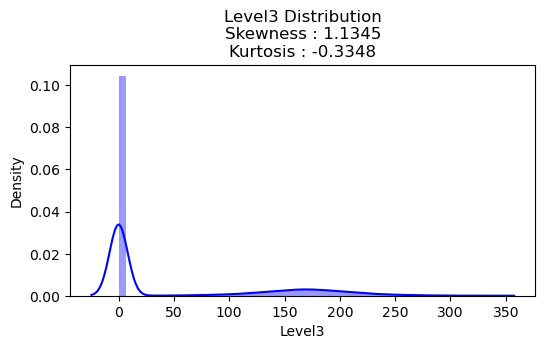

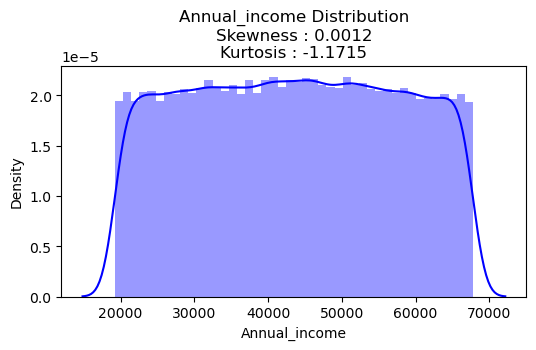

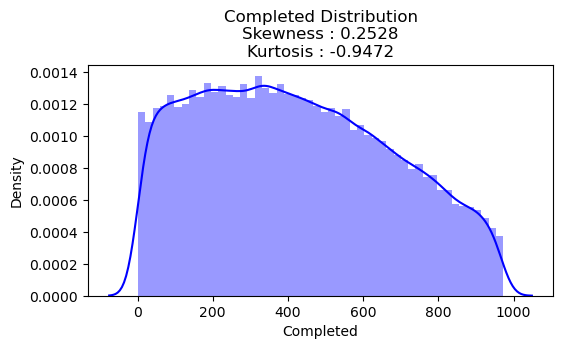

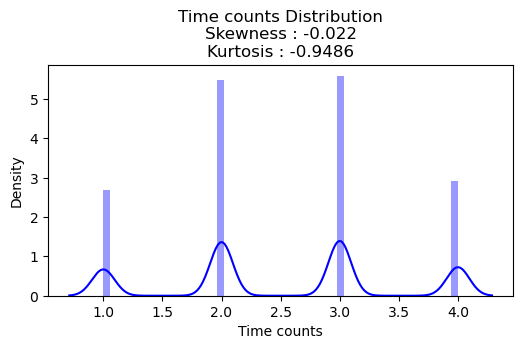

In [100]:
# distribution plots for all our numerical columns
for col_name in conti_columns:
    skew = round(df[col_name].skew(), 4)
    kurt = round(df[col_name].kurt(), 4)

    plt.figure(figsize=(6,3))
    sns.distplot(df[col_name], color="b")
    plt.title(f"{col_name} Distribution\nSkewness : {skew}\nKurtosis : {kurt}")
    plt.show()

OBSERVATIONS:
- Age is normally distributed
- Level 1, 2, and 3 are left skewed / negatively skewed distributions
- Annual income plot is uniform which indicates the population for this data was manually selected
- Completed shows a distribution skewing slightly towards right.

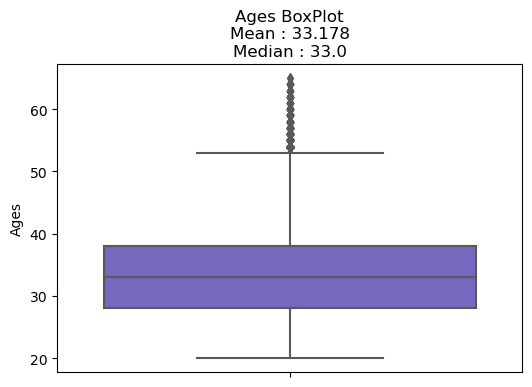

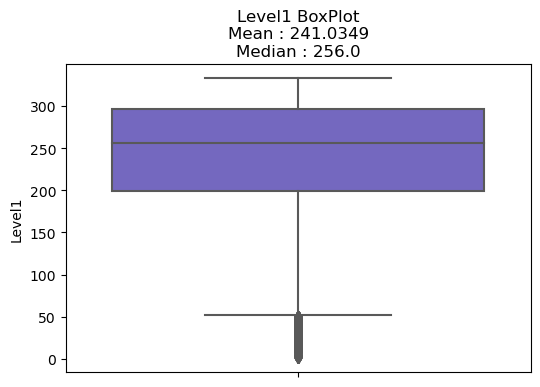

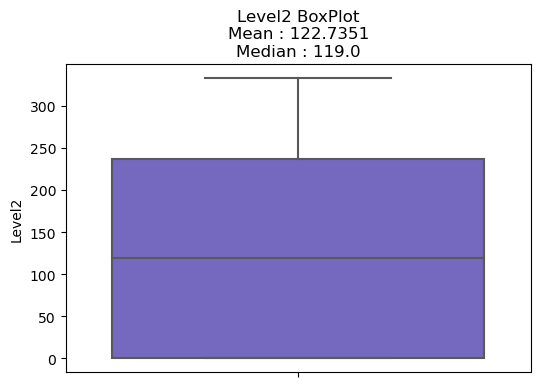

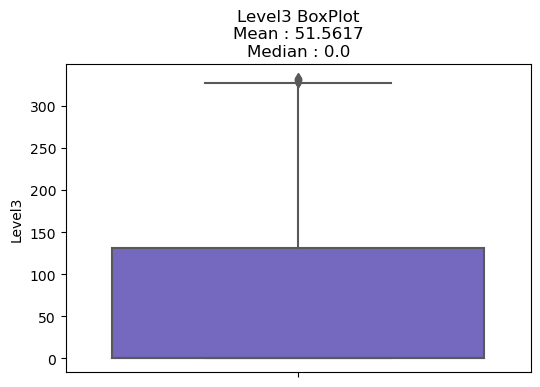

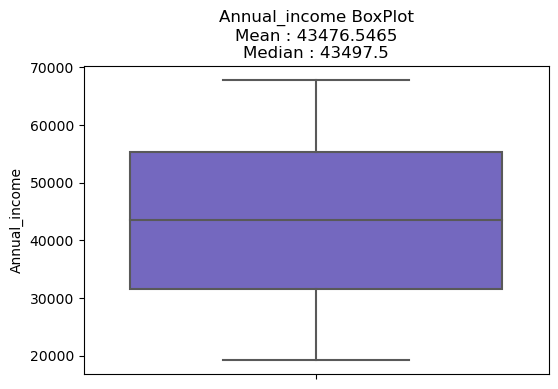

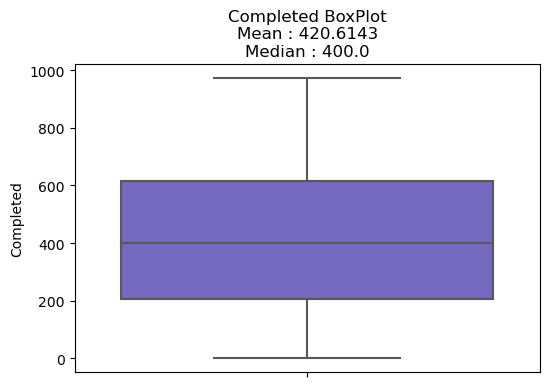

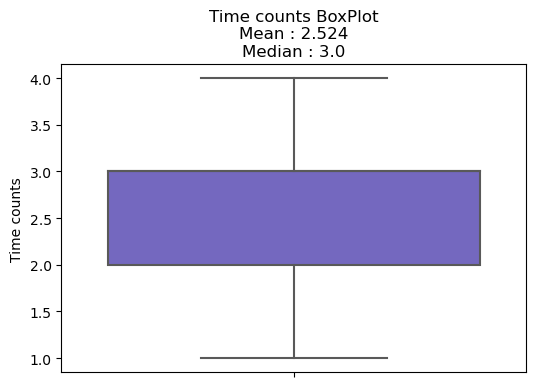

In [101]:
# box plots for all our numerical columns
for col_name in conti_columns:
    mean = round(df[col_name].mean(), 4)
    median = round(df[col_name].median(), 4)

    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col_name], color="slateblue")
    plt.title(f"{col_name} BoxPlot\nMean : {mean}\nMedian : {median}")
    plt.show()

OBSERVATIONS:
- We have outliers in Age and Level 1
- Few outliers in Level 3
- Annual income, completed and time counts are very robustly distributed

Although we see that we have quite some outliers but we will not be proceeding to remove them because the models we will be testing with such as Random Forest, Decision Tree, etc. are extremely robust to outliers since they get averaged out by aggregations of trees.

Feature Selection

In [102]:
df.head()

,Gender,Expertise,Ages,Level1,Level2,Level3,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,Female,beginner,34.0,315,180.0,0.0,monthly,67624.0,employed,medium,00:00-06:00,Active,android,phone,495,medium,4
1,Female,beginner,35.0,106,0.0,0.0,monthly,45968.0,NaN,NaN,06:00-12:00,Active,android,laptop,106,high,1
2,Female,beginner,38.0,327,300.0,319.0,annual,51810.0,NaN,high,12:00-18:00,Active,ios,tablet,946,low,4
3,Female,beginner,31.0,302,319.0,240.0,monthly,59311.0,employed,high,00:00-06:00,Active,ios,tablet,861,low,2
4,Female,beginner,32.0,329,121.0,0.0,annual,67741.0,self_employed,medium,00:00-06:00,Active,android,other,450,medium,4


In [103]:
# a chisq function to understand relationship b/w categorical features and target variable
def chisq_custom_function(df, col1, col2):    
    df_cont = pd.crosstab(index = df[col1], columns = df[col2])
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    df_cont.loc[:,'Total']= df_cont.sum(axis=1)
    df_cont.loc['Total']= df_cont.sum()
    df_exp = df_cont.copy()    
    df_exp.iloc[:,:] = np.multiply.outer(
        df_cont.sum(1).values,df_cont.sum().values) / df_cont.sum().sum()            
    df_chi2 = ((df_cont - df_exp)**2) / df_exp    
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1)
    df_chi2.loc['Total']= df_chi2.sum()

    print('\n-----------------------\n')
    display(df_chi2) 
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()
    
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    print(f"{col1} --- {col2}\nChi Square Score: {chi_square_score}\nDegrees of Freedom: {degree_f}\np-value: {p}")

In [104]:
# label encoding our target classes
label_en = LabelEncoder()
df["Churn"] = label_en.fit_transform(df["Churn"])
df["Churn"].value_counts()

2    47306
0    46590
1     6104
Name: Churn, dtype: int64

Point Biserial Correlation with significance

In [105]:
# point biserial correlation on continuous features with our target variable
conti_corr_df = (df[conti_columns].corrwith(df["Churn"], method=stats.pointbiserialr))
conti_corr_df.index = ["Correlation(R)", "p-value"]
conti_corr_df.round(5)

,Ages,Level1,Level2,Level3,Annual_income,Completed,Time counts
Correlation(R),-0.00911,0.0655,-0.07733,-0.3346,-0.01623,-0.15189,0.0863
p-value,0.00532,0.0000,0.00000,0.0000,0.00001,0.00000,0.0000


Chi Square tests with degrees of freedom and significance

In [106]:
for col in cate_columns:
    if col != "Churn":
        print("Chi-Square Tests")
        chisq_custom_function(df[cate_columns].apply(LabelEncoder().fit_transform),col, "Churn")

Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Gender,,,,
0,3.663060,0.498824,2.708236,6.870119
1,0.528324,0.071945,0.390609,0.990879
Total,4.191384,0.570769,3.098845,7.860998


Gender --- Churn
Chi Square Score: 7.860998302725081
Degrees of Freedom: 2
p-value: 0.019633869833868986
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Expertise,,,,
0,9.199773,0.819130,11.123411,21.142313
1,5.376025,3.702257,8.953130,18.031413
2,1.670350,0.597040,2.434095,4.701485
Total,16.246148,5.118427,22.510636,43.875211


Expertise --- Churn
Chi Square Score: 43.87521149597546
Degrees of Freedom: 4
p-value: 6.8103112572634384e-09
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Subs,,,,
0,0.148586,0.051075,0.215037,0.414697
1,0.018241,0.012993,0.030618,0.061852
2,0.349894,0.072712,0.467701,0.890306
Total,0.516720,0.136780,0.713355,1.366856


Subs --- Churn
Chi Square Score: 1.366855667687842
Degrees of Freedom: 4
p-value: 0.8499347119797903
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Job_status,,,,
0,0.162655,4.303362,0.118973,4.584990
1,0.062764,3.060271,0.144223,3.267257
2,1.151094,0.000289,1.146722,2.298106
3,0.072926,0.051316,0.122058,0.246300
4,1.320461,0.055360,1.114854,2.490674
Total,2.769900,7.470598,2.646829,12.887327


Job_status --- Churn
Chi Square Score: 12.88732679930698
Degrees of Freedom: 8
p-value: 0.11578558950713902
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Commitment,,,,
0,146.527007,20063.391724,3955.576376,24165.495107
1,6545.716373,429.024970,5307.223614,12281.964957
2,6767.056945,2309.463885,9781.160965,18857.681795
3,0.005631,0.159099,0.047415,0.212144
Total,13459.305956,22802.039677,19044.008370,55305.354003


Commitment --- Churn
Chi Square Score: 55305.354002938926
Degrees of Freedom: 6
p-value: 0.0
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Time,,,,
0,2.641585,2.913796,4.955591,10.510972
1,1.005892,0.165882,1.303305,2.475078
2,0.036115,0.172425,0.001555,0.210095
3,0.552707,0.632889,1.047680,2.233276
Total,4.236298,3.884992,7.308131,15.429421


Time --- Churn
Chi Square Score: 15.429421297354711
Degrees of Freedom: 6
p-value: 0.01716725324686373
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
State,,,,
0,1.872822,0.060217,2.091674,4.024713
1,47.360136,1.522783,52.894508,101.777428
Total,49.232958,1.583000,54.986183,105.802141


State --- Churn
Chi Square Score: 105.8021410706206
Degrees of Freedom: 2
p-value: 1.0601247644964595e-23
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Platform,,,,
0,0.390288,0.013244,0.437349,0.840880
1,0.484783,0.068782,0.616511,1.170076
2,0.402060,1.097718,1.011267,2.511046
Total,1.277131,1.179745,2.065127,4.522002


Platform --- Churn
Chi Square Score: 4.522002462961391
Degrees of Freedom: 4
p-value: 0.3399465236805955
Chi-Square Tests

-----------------------



Churn,0,1,2,Total
Device,,,,
0,0.004689,0.005630,0.009008,0.019327
1,0.224304,0.000466,0.213679,0.438449
2,1.560037,0.135574,1.881804,3.577415
3,0.537919,0.099667,0.707720,1.345306
Total,2.326949,0.241337,2.812212,5.380497


Device --- Churn
Chi Square Score: 5.380497242525351
Degrees of Freedom: 6
p-value: 0.4960162403780033


From the above statistical testings, we were able to select the relevant features to be used in our model building.

Alpha we used = 5%

In [107]:
selected_features = ["Ages", "Level1", "Level2", "Level3", "Completed", "Time counts", "Gender", "Expertise", "Commitment", "Time", "State"]

In [108]:
df = df[selected_features + ["Churn"]]
df.head()

,Ages,Level1,Level2,Level3,Completed,Time counts,Gender,Expertise,Commitment,Time,State,Churn
0,34.0,315,180.0,0.0,495,4,Female,beginner,medium,00:00-06:00,Active,2
1,35.0,106,0.0,0.0,106,1,Female,beginner,NaN,06:00-12:00,Active,0
2,38.0,327,300.0,319.0,946,4,Female,beginner,high,12:00-18:00,Active,1
3,31.0,302,319.0,240.0,861,2,Female,beginner,high,00:00-06:00,Active,1
4,32.0,329,121.0,0.0,450,4,Female,beginner,medium,00:00-06:00,Active,2


Feature selection completed.

One hot encoding

In [109]:
# we one hot encode our dataframe
ohe_df = pd.get_dummies(df)
print(ohe_df.shape)
ohe_df.head()

(100000, 21)


,Ages,Level1,Level2,Level3,Completed,Time counts,Churn,Gender_Female,Gender_Male,Expertise_Advanced,...,Expertise_beginner,Commitment_high,Commitment_low,Commitment_medium,Time_00:00-06:00,Time_06:00-12:00,Time_12:00-18:00,Time_18:00-00:00,State_Active,State_Inactive
0,34.0,315,180.0,0.0,495,4,2,1,0,0,...,1,0,0,1,1,0,0,0,1,0
1,35.0,106,0.0,0.0,106,1,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
2,38.0,327,300.0,319.0,946,4,1,1,0,0,...,1,1,0,0,0,0,1,0,1,0
3,31.0,302,319.0,240.0,861,2,1,1,0,0,...,1,1,0,0,1,0,0,0,1,0
4,32.0,329,121.0,0.0,450,4,2,1,0,0,...,1,0,0,1,1,0,0,0,1,0


In [110]:
ohe_df.isna().sum().values # check for missing values

array([6424,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64)

We see that we still have some null values. To tackle this, we will use nearest neighbours imputation.

Pre-Processing

In [111]:
# we create our X (features) and y (target) data
X = ohe_df.drop("Churn", axis=1)
y = ohe_df["Churn"]

In [112]:
# we impute the missing values using 7 nearest neighbours
imputer = KNNImputer(n_neighbors=7, weights="distance")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [113]:
# we scale our dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [114]:
# we train test split our dataset with a split size of 20% (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=45, stratify=y)

We use stratification because we have an imbalance in classes.

In [115]:
y_train.value_counts(normalize=True)*100, y_test.value_counts(normalize=True)*100

(2    47.30625
 0    46.59000
 1     6.10375
 Name: Churn, dtype: float64,
 2    47.305
 0    46.590
 1     6.105
 Name: Churn, dtype: float64)

We see that we still have the class imbalance. To tackle this, we will use Synthetic Minority Oversampling Technique(SMOTE). SMOTE is a widely used technique that works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [116]:
# we use SMOTE to balance the classes in our training set
sm = SMOTE(random_state=45)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [117]:
y_res.value_counts(normalize=True)*100

2    33.333333
0    33.333333
1    33.333333
Name: Churn, dtype: float64

We see that the classes in our training set are balanced now.

##### Model Building

In [118]:
# import models to test
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [119]:
# function to get metrics
def get_metrics(true, pred, model_name):
    f1_macro = f1_score(true, pred, average="macro")
    print(f"\n###--- {model_name} ---###\n### F1-Score(Macro): {round(f1_macro*100, 1)}% ###")
    print(classification_report(true, pred))
    sns.heatmap(confusion_matrix(true, pred), annot=True, fmt=".0f", cmap="Blues")
    plt.show()
    return round(f1_macro*100, 1)

In [120]:
models_dict = {
    "Random Forest" : RandomForestClassifier(n_jobs=-1),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "C-Support Vector" : SVC(),
    "Decision Tree" : DecisionTreeClassifier(),
    "K-Neigbors" : KNeighborsClassifier(n_jobs=-1),
    "Gaussian Naive Bayes" : GaussianNB()
}

In [121]:
def eval_models():
    models_df = pd.DataFrame(columns=["Model", "F1-Score(Macro)", "Time Taken"])
    index = 0
    for clf_name, model in models_dict.items():
        start_time = time.time()
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        time_taken = time.time() - start_time
        f1_macro = get_metrics(y_test, y_pred, clf_name)
        to_push = (clf_name, f1_macro, time_taken)
        models_df.loc[index] = to_push
        index += 1
    return models_df


###--- Random Forest ---###
### F1-Score(Macro): 67.3% ###
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      9318
           1       0.43      0.61      0.50      1221
           2       0.80      0.80      0.80      9461

    accuracy                           0.74     20000
   macro avg       0.65      0.70      0.67     20000
weighted avg       0.75      0.74      0.74     20000



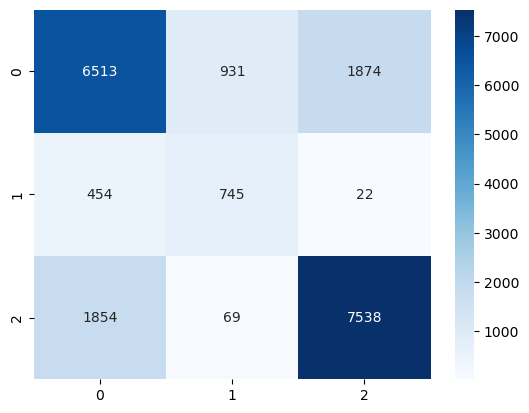


###--- Gradient Boosting ---###
### F1-Score(Macro): 67.5% ###
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      9318
           1       0.39      0.74      0.51      1221
           2       0.81      0.80      0.81      9461

    accuracy                           0.74     20000
   macro avg       0.65      0.74      0.68     20000
weighted avg       0.76      0.74      0.74     20000



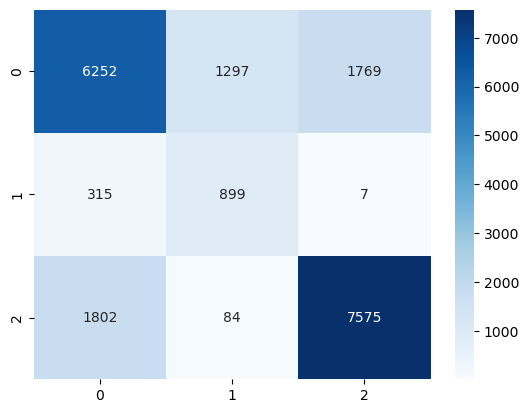


###--- AdaBoost ---###
### F1-Score(Macro): 65.7% ###
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      9318
           1       0.36      0.75      0.48      1221
           2       0.81      0.79      0.80      9461

    accuracy                           0.72     20000
   macro avg       0.63      0.73      0.66     20000
weighted avg       0.75      0.72      0.73     20000



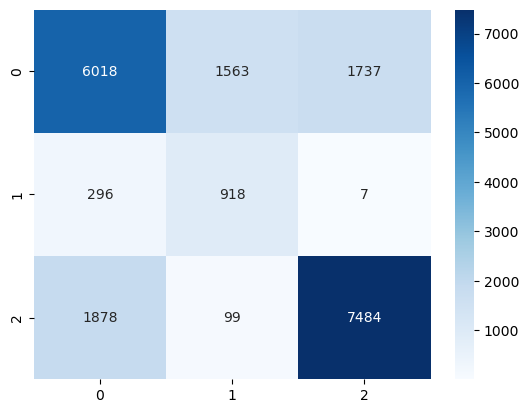


###--- C-Support Vector ---###
### F1-Score(Macro): 64.6% ###
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      9318
           1       0.34      0.77      0.47      1221
           2       0.79      0.81      0.80      9461

    accuracy                           0.71     20000
   macro avg       0.63      0.73      0.65     20000
weighted avg       0.74      0.71      0.72     20000



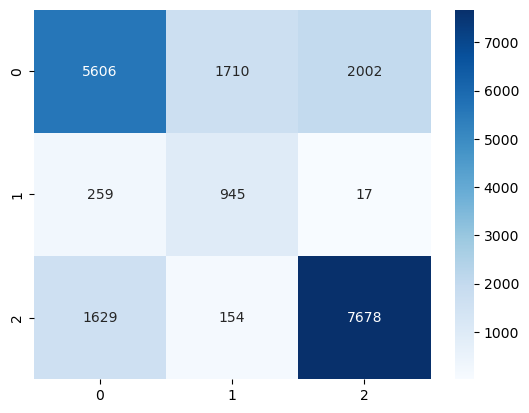


###--- Decision Tree ---###
### F1-Score(Macro): 56.9% ###
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      9318
           1       0.30      0.52      0.38      1221
           2       0.72      0.71      0.71      9461

    accuracy                           0.64     20000
   macro avg       0.55      0.61      0.57     20000
weighted avg       0.65      0.64      0.64     20000



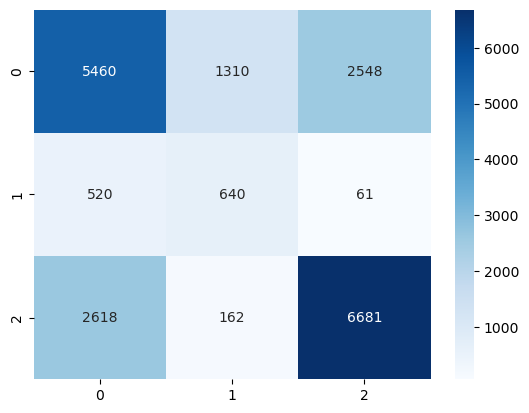


###--- K-Neigbors ---###
### F1-Score(Macro): 61.2% ###
              precision    recall  f1-score   support

           0       0.71      0.61      0.65      9318
           1       0.30      0.64      0.41      1221
           2       0.78      0.77      0.78      9461

    accuracy                           0.69     20000
   macro avg       0.59      0.67      0.61     20000
weighted avg       0.72      0.69      0.70     20000



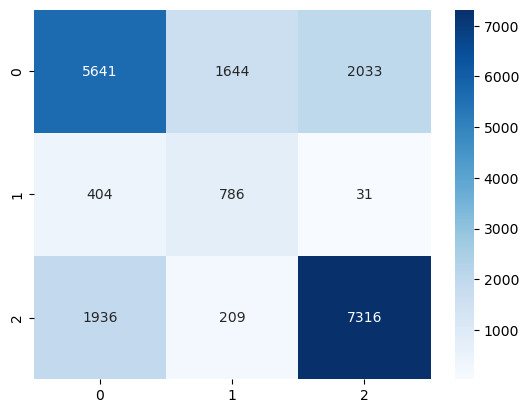


###--- Gaussian Naive Bayes ---###
### F1-Score(Macro): 55.2% ###
              precision    recall  f1-score   support

           0       0.72      0.40      0.51      9318
           1       0.24      0.80      0.37      1221
           2       0.73      0.83      0.77      9461

    accuracy                           0.63     20000
   macro avg       0.56      0.68      0.55     20000
weighted avg       0.69      0.63      0.63     20000



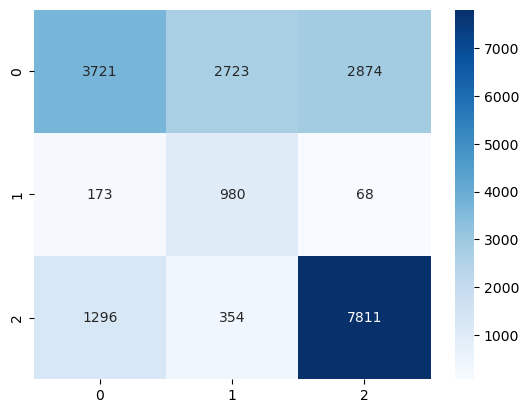

In [35]:
evaluate_models_df = eval_models()

In [31]:
evaluate_models_df.sort_values(["F1-Score(Macro)", "Time Taken"], ascending=False)

,Model,F1-Score(Macro),Time Taken
1,Gradient Boosting,67.5,43.467105
0,Random Forest,67.4,2.846900
2,AdaBoost,65.7,3.570937
3,C-Support Vector,64.6,559.249589
5,K-Neigbors,61.2,1.398191
4,Decision Tree,56.9,0.629961
6,Gaussian Naive Bayes,55.2,0.042003


We see that Gradient Boosting is our best model on f1-score(macro) evaluation. Also, from the above models, we are able to see that Random Forest and Adaboost has strong performance on the minority class. Thus, we will define a custom voting classifier using the best 3 models only for our minority class.

In [32]:
gbc_base = GradientBoostingClassifier()
gbc_base.fit(X_res, y_res)

GradientBoostingClassifier()


###--- GBC_Train ---###
### F1-Score(Macro): 67.7% ###
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     37272
           1       0.40      0.76      0.52      4883
           2       0.81      0.80      0.80     37845

    accuracy                           0.74     80000
   macro avg       0.65      0.74      0.68     80000
weighted avg       0.75      0.74      0.74     80000



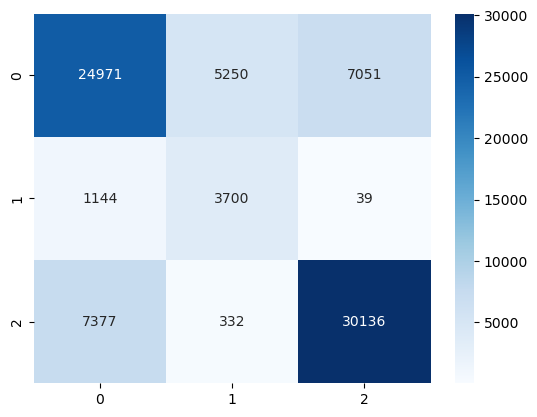

67.7

In [33]:
# Training set metrics evaluation
get_metrics(y_train, gbc_base.predict(X_train), "GBC_Train")


###--- GBC_Test ---###
### F1-Score(Macro): 67.5% ###
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      9318
           1       0.39      0.74      0.51      1221
           2       0.81      0.80      0.81      9461

    accuracy                           0.74     20000
   macro avg       0.65      0.74      0.68     20000
weighted avg       0.76      0.74      0.74     20000



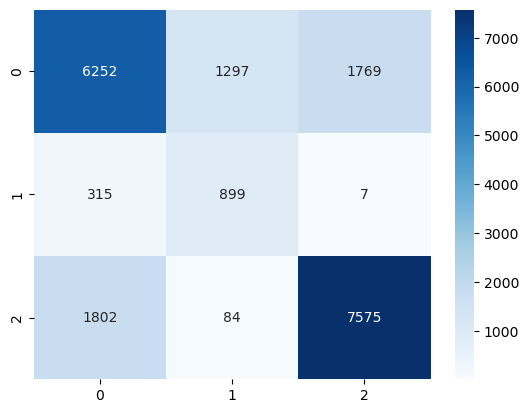

67.5

In [34]:
# Testing set metrics evaluation
get_metrics(y_test, gbc_base.predict(X_test), "GBC_Test")

From the above metrics evaluations, we are able to see that our model is not overfitting and is perfectly generalised. Further, we will try to hyper parameter tune our primary model, i.e., Gradient Boosting Classifier.

In [39]:
param_grid = {'learning_rate': [0.01, 0.1],
                  'subsample'    : [1, 0.7], #stochastic gradient boosting experimentation
                  'n_estimators' : [100, 500],
                  'max_depth'    : [3, 5]
                 }

gbc_opt = GridSearchCV(estimator=gbc_base, param_grid=param_grid, cv=3, n_jobs=-1, verbose=True, scoring="f1_macro") # 3 folds of stratified cross validation
gbc_opt.fit(X_res, y_res)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 500], 'subsample': [1, 0.7]},
             scoring='f1_macro', verbose=True)

In [40]:
# we check the parameters of the best GBC model
gbc_opt.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 1}

In [41]:
# Initializing and fitting our best GBC model
gbc_best = gbc_opt.best_estimator_
gbc_best.fit(X_res, y_res)

GradientBoostingClassifier(max_depth=5, n_estimators=500, subsample=1)

Next we prepare our two supporting models for minority class.

In [38]:
# Random Forest model
rfc_model = RandomForestClassifier(n_jobs=-1)
rfc_model.fit(X_res, y_res)

RandomForestClassifier(n_jobs=-1)

In [39]:
# Adaboost model
adb_model = AdaBoostClassifier()
adb_model.fit(X_res, y_res)

AdaBoostClassifier()

A custom function to ensemble votes for inference on only minority class.

In [41]:
def minority_voting_classifier(df_row):
    # input_df_ohe = pd.get_dummies(df_row).reindex(columns = ohe_df.drop("Churn", axis=1).columns, fill_value=0)
    # input_df_ohe = pd.DataFrame(imputer.transform(input_df_ohe), columns=input_df_ohe.columns)
    # input_df_ohe = scaler.transform(input_df_ohe)
    input_df_ohe = [df_row]

    gbc_pred = gbc_best.predict(input_df_ohe)
    rfc_pred = rfc_model.predict(input_df_ohe)
    adb_pred = adb_model.predict(input_df_ohe)
    
    combined_pred = [gbc_pred[0], rfc_pred[0], adb_pred[0]]

    if combined_pred.count(1) >= 2:
        pred = 1
    else:
        pred = gbc_pred[0]

    # pred = label_en.inverse_transform([pred])
    return pred

In [91]:
voting_pred = []
for row in tqdm(X_test):
    pred = minority_voting_classifier(row)
    voting_pred.append(pred)

100%|██████████| 20000/20000 [04:18<00:00, 77.25it/s]



###--- Minority Voting Classifier ---###
### F1-Score(Macro): 67.1% ###
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      9318
           1       0.41      0.62      0.49      1221
           2       0.81      0.80      0.80      9461

    accuracy                           0.74     20000
   macro avg       0.65      0.71      0.67     20000
weighted avg       0.75      0.74      0.74     20000



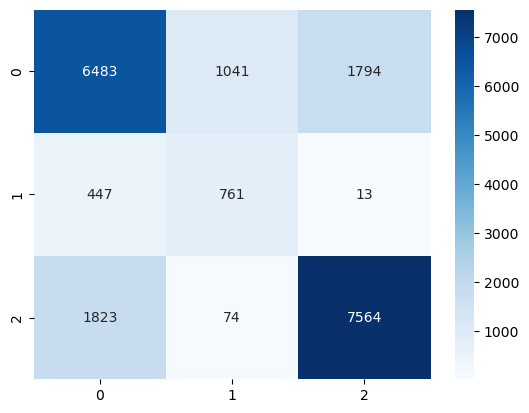

67.1

In [93]:
# minority voting classifier evaluation
get_metrics(y_test, voting_pred, "Minority Voting Classifier")

We see that our minority class precision and recall are more balanced.

Next, we will save the necessary files required for our dashboard.

In [43]:
with open("pickle_files\gbc_best.pkl", "wb") as f: # gbc model
    pickle.dump(gbc_best, f)

with open("pickle_files\\rfc_model.pkl", "wb") as f: # svc model
    pickle.dump(rfc_model, f)

with open("pickle_files\\adb_model.pkl", "wb") as f: # gnb model
    pickle.dump(adb_model, f)

with open("pickle_files\ohe_columns.pkl", "wb") as f: # one hot encoded columns
    pickle.dump(ohe_df.drop("Churn", axis=1).columns, f)

with open("pickle_files\imputer.pkl", "wb") as f: # imputer
    pickle.dump(imputer, f)

with open("pickle_files\scaler.pkl", "wb") as f: # scaler
    pickle.dump(scaler, f)

with open("pickle_files\label_encoder.pkl", "wb") as f: # label encoder
    pickle.dump(label_en, f)

#### **CLUSTERING**

In [38]:
# import required libraries
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [39]:
# re-import dataset
df = pd.read_csv("Synthetic_Churn.csv")
df.head()

,Gender,Expertise,Ages,Level1,Level2,Level3,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,Female,beginner,34.0,315,180.0,NaN,monthly,67624.0,employed,medium,00:00-06:00,Active,android,phone,495,medium,4
1,Female,beginner,35.0,106,NaN,NaN,monthly,45968.0,NaN,NaN,06:00-12:00,Active,android,laptop,106,high,1
2,Female,beginner,38.0,327,300.0,319.0,annual,51810.0,NaN,high,12:00-18:00,Active,ios,tablet,946,low,4
3,Female,beginner,31.0,302,319.0,240.0,monthly,59311.0,employed,high,00:00-06:00,Active,ios,tablet,861,low,2
4,Female,beginner,32.0,329,121.0,NaN,annual,67741.0,self_employed,medium,00:00-06:00,Active,android,other,450,medium,4


In [40]:
# label encoding categorical features
label_encoder = LabelEncoder()
for i in df[cate_columns]:
    df[i] = df[[i]].apply(label_encoder.fit_transform)

In [41]:
df.head() # label encoded

,Gender,Expertise,Ages,Level1,Level2,Level3,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,0,2,34.0,315,180.0,NaN,1,67624.0,0,2,0,0,0,2,495,2,4
1,0,2,35.0,106,NaN,NaN,1,45968.0,4,3,1,0,0,0,106,0,1
2,0,2,38.0,327,300.0,319.0,0,51810.0,4,0,2,0,1,3,946,1,4
3,0,2,31.0,302,319.0,240.0,1,59311.0,0,0,0,0,1,3,861,1,2
4,0,2,32.0,329,121.0,NaN,0,67741.0,2,2,0,0,0,1,450,2,4


In [42]:
df.drop(["Level1", "Level2", "Level3"], axis=1, inplace=True)

In [43]:
# imputed missing values
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(data=imputer.fit_transform(df), columns=df.columns)
df.head()

,Gender,Expertise,Ages,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,0.0,2.0,34.0,1.0,67624.0,0.0,2.0,0.0,0.0,0.0,2.0,495.0,2.0,4.0
1,0.0,2.0,35.0,1.0,45968.0,4.0,3.0,1.0,0.0,0.0,0.0,106.0,0.0,1.0
2,0.0,2.0,38.0,0.0,51810.0,4.0,0.0,2.0,0.0,1.0,3.0,946.0,1.0,4.0
3,0.0,2.0,31.0,1.0,59311.0,0.0,0.0,0.0,0.0,1.0,3.0,861.0,1.0,2.0
4,0.0,2.0,32.0,0.0,67741.0,2.0,2.0,0.0,0.0,0.0,1.0,450.0,2.0,4.0


In [44]:
# scale dataset with standard scaler
scaler = StandardScaler()
df = pd.DataFrame(data=scaler.fit_transform(df), columns=df.columns)
df.head()

,Gender,Expertise,Ages,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts
0,-2.633127,0.342289,0.116544,0.599056,1.898106,-1.581498,0.400833,-1.397641,-0.198857,-1.023066,0.438479,0.292011,1.024631,1.538021
1,-2.633127,0.342289,0.257113,0.599056,0.196907,1.115842,1.552621,-0.496286,-0.198857,-1.023066,-1.335950,-1.235060,-1.039410,-1.587953
2,-2.633127,0.342289,0.678818,-0.953948,0.655828,1.115842,-1.902741,0.405069,-0.198857,0.900894,1.325694,2.062470,-0.007389,1.538021
3,-2.633127,0.342289,-0.305162,0.599056,1.245074,-1.581498,-1.902741,-1.397641,-0.198857,0.900894,1.325694,1.728792,-0.007389,-0.545962
4,-2.633127,0.342289,-0.164593,-0.953948,1.907297,-0.232828,0.400833,-1.397641,-0.198857,-1.023066,-0.448735,0.115357,1.024631,1.538021


PCA

In [45]:
pca = PCA(n_components=10)
pca.fit(df)
PCA_ds = pd.DataFrame(pca.transform(df), columns=(["col1","col2", "col3", "col4","col5", "col6", "col7","col8", "col9", "col10"]))
PCA_ds.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
col1,100000.0,-0.0,1.299,-3.332,-0.977,0.012,0.966,3.890
col2,100000.0,0.0,1.181,-2.743,-1.017,-0.170,1.098,3.444
col3,100000.0,-0.0,1.068,-1.785,-0.687,-0.343,0.310,6.466
col4,100000.0,0.0,1.023,-3.594,-0.717,-0.016,0.697,4.025
col5,100000.0,0.0,1.013,-3.127,-0.718,-0.028,0.690,4.079
col6,100000.0,-0.0,1.001,-3.327,-0.725,-0.003,0.718,3.543
col7,100000.0,-0.0,0.998,-3.221,-0.717,-0.017,0.698,3.836
col8,100000.0,0.0,0.993,-3.562,-0.704,0.003,0.707,3.698
col9,100000.0,0.0,0.988,-3.636,-0.697,-0.018,0.683,4.050
col10,100000.0,-0.0,0.981,-3.897,-0.659,0.001,0.655,4.040


In [46]:
sum(pca.explained_variance_ratio_)

0.8013995099626151

We are able to explain 73% of total variance with 10 features.

Clustering

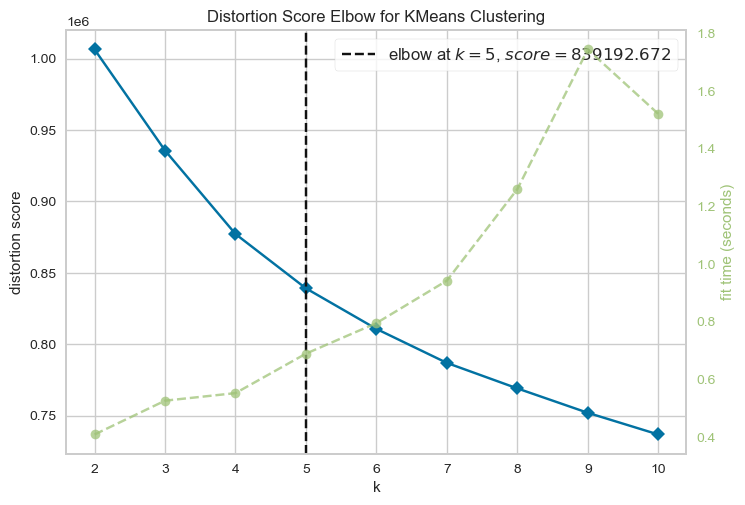

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# determination of clusters
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [48]:
KM = KMeans(n_clusters=5)
clusters_array = KM.fit_predict(df)

In [49]:
# reimport clean dataset with clusters appended
df = pd.read_csv("Synthetic_Churn.csv")
df["Clusters"] = clusters_array
df.head()

,Gender,Expertise,Ages,Level1,Level2,Level3,Subs,Annual_income,Job_status,Commitment,Time,State,Platform,Device,Completed,Churn,Time counts,Clusters
0,Female,beginner,34.0,315,180.0,NaN,monthly,67624.0,employed,medium,00:00-06:00,Active,android,phone,495,medium,4,3
1,Female,beginner,35.0,106,NaN,NaN,monthly,45968.0,NaN,NaN,06:00-12:00,Active,android,laptop,106,high,1,3
2,Female,beginner,38.0,327,300.0,319.0,annual,51810.0,NaN,high,12:00-18:00,Active,ios,tablet,946,low,4,3
3,Female,beginner,31.0,302,319.0,240.0,monthly,59311.0,employed,high,00:00-06:00,Active,ios,tablet,861,low,2,3
4,Female,beginner,32.0,329,121.0,NaN,annual,67741.0,self_employed,medium,00:00-06:00,Active,android,other,450,medium,4,3


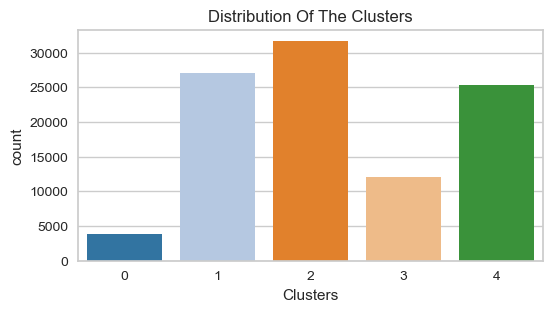

In [50]:
plt.figure(figsize=(6,3))
pl = sns.countplot(x=df["Clusters"], palette="tab20")
pl.set_title("Distribution Of The Clusters")
plt.show()

In [51]:
df["Clusters"].value_counts(normalize=True)*100 # normalized distribution

2    31.723
1    27.009
4    25.405
3    12.059
0     3.804
Name: Clusters, dtype: float64